# Prereqs and config
---

In [1]:
# Standard library

# Scientific computing
import numpy as np
import powerlaw
from sklearn.metrics import normalized_mutual_info_score as nmiscore

# Network science
import networkx as nx
import community as louvain

# Data management
import pandas as pd
from tabulate import tabulate

# Data viz
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Choosing and loading multiplex
---

In [2]:
# Network config
networks = ["arxiv", "celegans", "drosophila", "london"]  # Common names for multiplexes (alphabetized)
NUM_LAYERS_ = {
    "arxiv": 13,
    "celegans": 3,
    "drosophila": 7,
    "london": 3,
}

# * Choosing a network! Remmeber Python is 0 indexed.
IDX = 2
NUM_LAYERS = NUM_LAYERS_[networks[IDX]]

# Loading network
## Reading raw text edgelist
with open("data/multiplexes/multiplex_network-{}.edgelist".format(networks[IDX])) as _f:
    lines = _f.readlines()

## Formatting as dictionary {layer: edgelist}
lines= [line.split(" ") for line in lines]
multiplex = {int(line[0]): [] for line in lines}
for line in lines:
    edge = (int(line[1]), int(line[2]))
    multiplex[int(line[0])].append(edge)


# Creating array of nx.Graph objects for each layer
S_nx = [
    nx.Graph(edgelist)
    for edgelist in multiplex.values()
]

## Don't look at this, I am ashamed

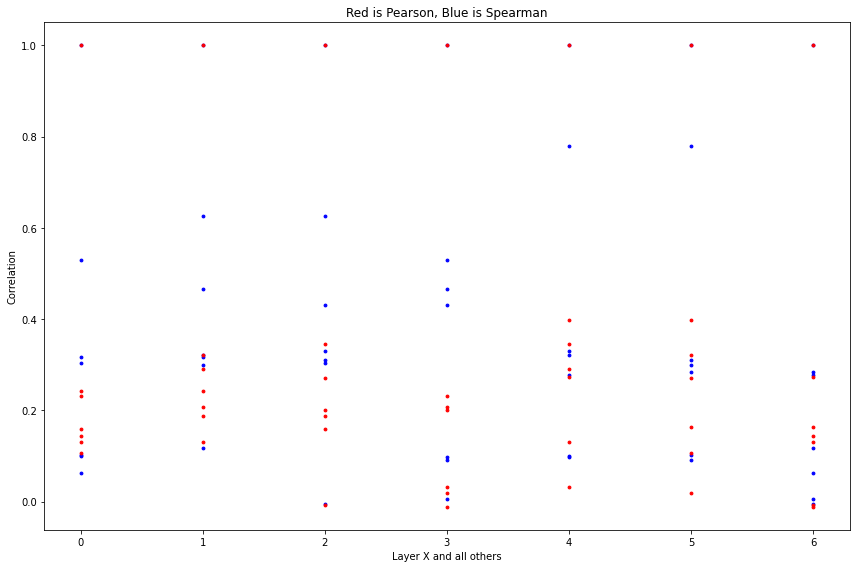

In [3]:
from scipy.stats import spearmanr as sp
from scipy.stats import pearsonr as pr
plt.figure(figsize=(12,8))
for c in range(NUM_LAYERS):
    rhos = []
    rhos_p = []
    for d in range(NUM_LAYERS):
        deg1 = dict(S_nx[c].degree())
        deg2 = dict(S_nx[d].degree())
        for node in set(deg1.keys()) | set(deg2.keys()):
            if node not in deg1:
                deg1[node] = 0
            if node not in deg2:
                deg2[node] = 0

        a = list(deg1.values())
        b = list(deg2.values())
        if len(b) < len(a):
            b = b + [0]*(len(a)-len(b))
        else:
            a = a + [0]*(len(b)-len(a))

        rho, _ = sp(a, b)
        rho_p, _ = pr(a, b)
        rhos.append(rho)
        rhos_p.append(rho_p)
    plt.scatter([c]*len(rhos), rhos, label="{}".format(c), s=8, color="blue")
    plt.scatter([c]*len(rhos), rhos_p, label="{}".format(c), s=8, color="red")
#plt.legend()
plt.xlabel("Layer X and all others")
plt.ylabel("Correlation")
plt.title("Red is Pearson, Blue is Spearman")
plt.tight_layout()


# Layerwise summary analysis
---

## Basic stats

In [4]:
df = pd.DataFrame({})

for IDX, _ in enumerate(networks):
    S_nx = load_multiplex(IDX)
    NUM_LAYERS = NUM_LAYERS_[networks[IDX]]

    names=[str(x) for x in range(1, NUM_LAYERS+1)]
    df_data=[]

    for no,g in enumerate(S_nx):
        n,e=g.number_of_nodes(),g.number_of_edges()
        comps=len([len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)])
        GCC=[len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)]
        gcc=GCC[0]/n
        comm_het = powerlaw.Fit(GCC, verbose=False)
        comm_het = comm_het.power_law.alpha
        d=[j for _,j in g.degree()]
        d2=[j**2 for j in d]
        het=np.mean(d2)/(np.mean(d))**2
        df_data.append((names[no],n,e,comps,gcc,het,comm_het))

    # ! Adjust each layer to have consistent node set
    common_node_set_ = [set(layer.nodes) for layer in S_nx]  # NOT COMMON YET
    common_node_set_ = set().union(*common_node_set_)
    S_nx_common_nodes = [nx.Graph() for _ in S_nx]
    for idx_, graph in enumerate(S_nx_common_nodes):
        graph.add_nodes_from(common_node_set_)
        graph.add_edges_from(S_nx[idx_].edges)

    S_nx_bkp = S_nx.copy()
    S_nx = S_nx_common_nodes

    # Get partitions
    partitions = [louvain.best_partition(layer) for layer in S_nx]

    # Get modularity for each partition
    graph_partition_pairs = zip(S_nx, partitions)
    modularities = [
        louvain.modularity(partition, graph)
        for graph, partition in graph_partition_pairs
    ]

    df_=pd.DataFrame(df_data,columns=['Layer Id','Nodes','Edges','Components','GCC','Degree Heterogeneity','Disconnected Components power-law fit'])
    df_["Network"] = [networks[IDX]]*len(df_)
    df_["Modularities"] = modularities

    df = pd.concat([df, df_])


print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))
df.to_csv("basicstats.csv")

NameError: name 'load_multiplex' is not defined

### Community structure

Text(0.5, 1.0, 'Modularity of Louvain partitions on drosophila layers')

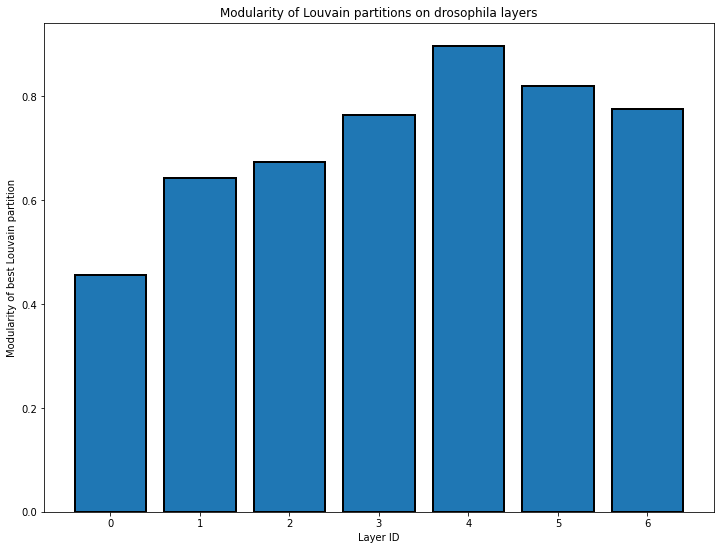

In [ ]:
# ! Adjust each layer to have consistent node set
common_node_set_ = [set(layer.nodes) for layer in S_nx]  # NOT COMMON YET
common_node_set_ = set().union(*common_node_set_)
S_nx_common_nodes = [nx.Graph() for _ in S_nx]
for idx_, graph in enumerate(S_nx_common_nodes):
    graph.add_nodes_from(common_node_set_)
    graph.add_edges_from(S_nx[idx_].edges)

S_nx_bkp = S_nx.copy()
S_nx = S_nx_common_nodes

# Get partitions
partitions = [louvain.best_partition(layer) for layer in S_nx]

# Get modularity for each partition
graph_partition_pairs = zip(S_nx, partitions)
modularities = [
    louvain.modularity(partition, graph)
    for graph, partition in graph_partition_pairs
]

# Quick distribution of modularity in each layer
## Plotting data
plt.figure(figsize=(12,9))
plt.bar(
    x=range(len(modularities)), height=modularities,
    edgecolor="black", linewidth=2
)

## Adjusting ticks and labels
plt.xticks(range(len(modularities)))
plt.xlabel("Layer ID")
plt.ylabel("Modularity of best Louvain partition")
plt.title("Modularity of Louvain partitions on {} layers".format(networks[IDX]))

# Inter-layer analysis
---

## Computations

In [ ]:
# Book-keeping
nodeoverlap_df_ = []  # Array tracking node overlap
edgeoverlap_df_ = []  # Array tracking edge overlap
ratios_df_ = []  # Array tracking ratio of average degrees between two layers
NMIs_df_ = []  # Array tracking NMI of partitions

# Looping over layer comparisons (left layer)
for no1,g1 in enumerate(S_nx):
    # Set up some intermediary data struct before dataframe
    temp_nodes = [0]*NUM_LAYERS  # One by one layer pairing node overlap
    temp_edges = [0]*NUM_LAYERS  # Same for edges
    temp_ratios = [0]*NUM_LAYERS  # Same for ratio of average degrees
    temp_nmis = [0]*NUM_LAYERS  # Same for partition NMIs

    # Looping over layer comparisons (right layer)
    for no2,g2 in enumerate(S_nx):
        # Get node overlap
        S1,S2=set(g1.nodes()),set(g2.nodes())
        J=len(S1.intersection(S2))/len(S1.union(S2))
        temp_nodes[no2]=J

        # Get edge overlap
        S1,S2=set(g1.edges()),set(g2.edges())
        J=len(S1.intersection(S2))/len(S1.union(S2))
        temp_edges[no2]=J

        # Get ratios of average degrees
        av1 = np.mean([x[1] for x in g1.degree()])
        av2 = np.mean([x[1] for x in g2.degree()])
        if av1 > av2:
            temp_ratios[no2] = av2/av1
        else:
            temp_ratios[no2] = av1/av2

        # Get partition NMIs
        ## Get relevant partitions
        partitions_ = (partitions[no1], partitions[no2])
        partition_values_ = (list(partition.values()) for partition in partitions_)

        ## Plug into NMI calculation
        temp_nmis[no2] = nmiscore(*partition_values_)


    # Cumulatively add to dataframe
    nodeoverlap_df_.append(temp_nodes)
    edgeoverlap_df_.append(temp_edges)
    ratios_df_.append(temp_ratios)
    NMIs_df_.append(temp_nmis)

nodeoverlap_df = pd.DataFrame(nodeoverlap_df_, columns=names,index=names)
edgeoverlap_df = pd.DataFrame(edgeoverlap_df_, columns=names,index=names)
ratios_df = pd.DataFrame(ratios_df_, columns=names,index=names)
NMIs_df = pd.DataFrame(NMIs_df_, columns=names,index=names)

## Plotting

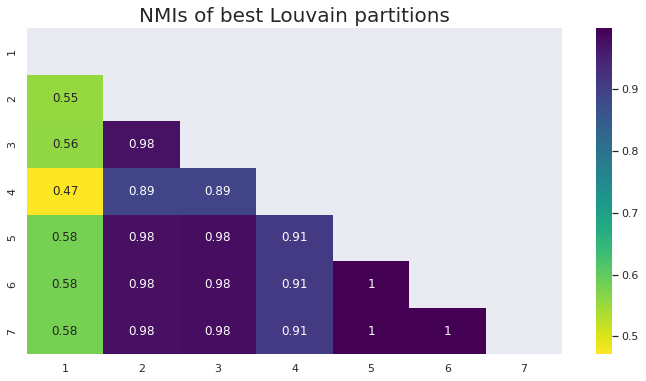

In [ ]:
# Node overlap
if 0:  # * If statement purely to toggle plot visibility
    plt.figure()
    sns.set(rc = {'figure.figsize':(12,6)})
    sns.heatmap(nodeoverlap_df, annot=True, cmap='viridis_r')
    plt.title('Node Overlap between layers',fontsize=20)

# Edge overlap
if 0:
    plt.figure()
    sns.set(rc = {'figure.figsize':(12,6)})
    sns.heatmap(edgeoverlap_df, annot=True, cmap='viridis_r')
    plt.title('Edge Overlap between layers',fontsize=20)

# Ratios of average degrees
if 0:
    plt.figure()
    sns.set(rc = {'figure.figsize':(12,6)})
    sns.heatmap(ratios_df, annot=True, cmap='viridis_r')
    plt.title('Ratio of average degrees',fontsize=20)

# NMIs of partitions
if 1:
    plt.figure()
    sns.set(rc = {'figure.figsize':(12,6)})
    mask = np.triu(NMIs_df) # - np.identity(len(NMIs_df))
    sns.heatmap(NMIs_df, annot=True, cmap='viridis_r', mask=mask)
    plt.title('NMIs of best Louvain partitions',fontsize=20)

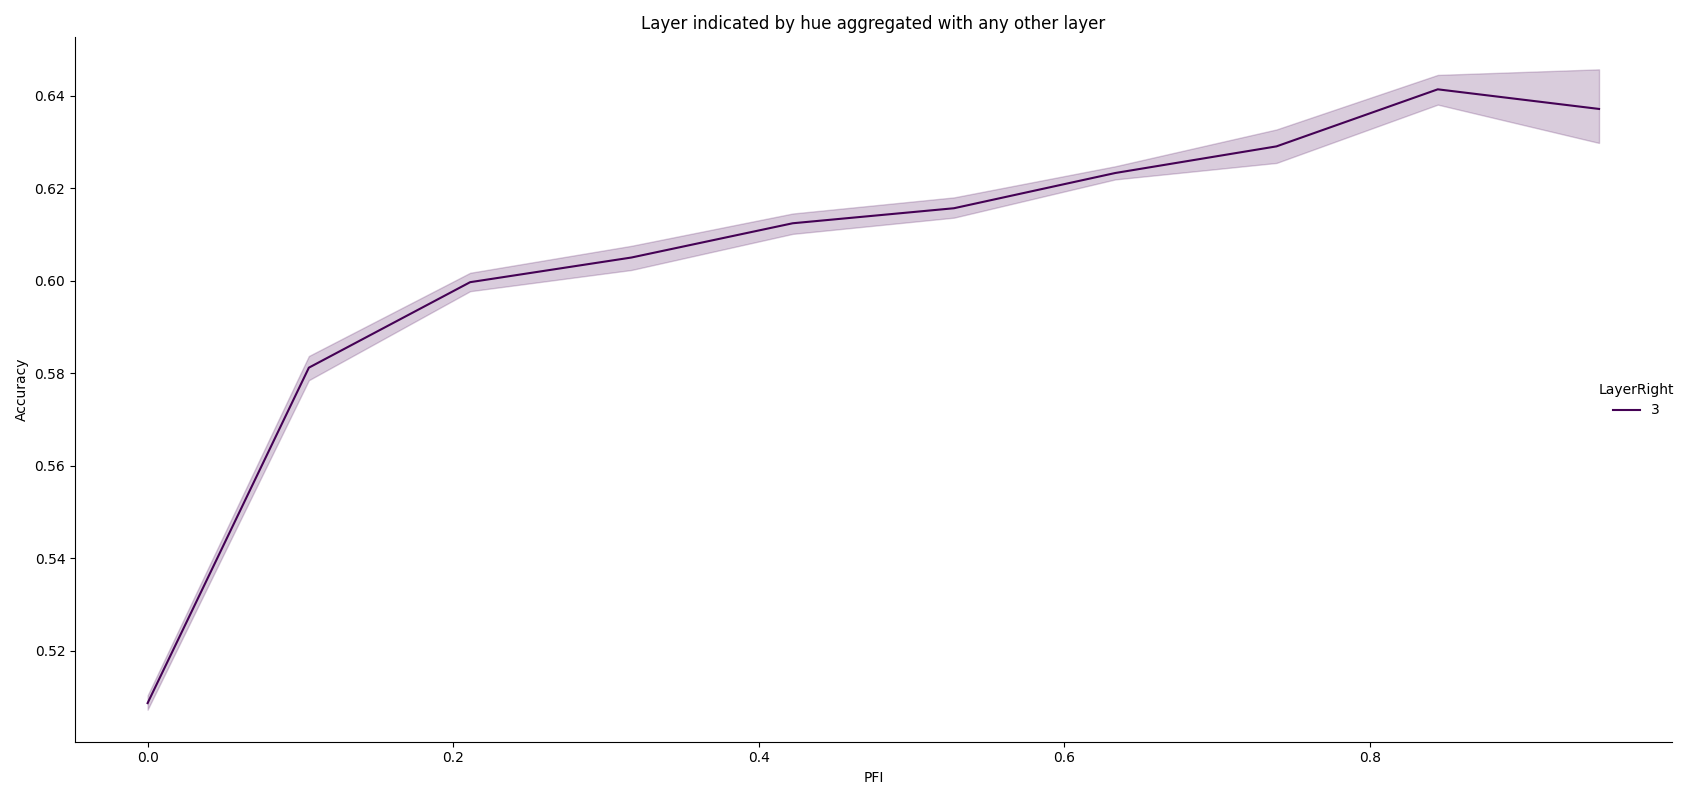

In [ ]:
# ! FOR SPECIFICALLY DROSOPHILA LAYERS 2 AND 3
Image(filename='results/drosophila_left-2_right-3.png')

## Merging dataframes

In [ ]:
# * Combining melted dataframes of all these measure
## Setting up convenient book-keeping for labels
vals = {
    0: "Node Overlap",
    1: "Edge Overlap",
    2: "Ratio",
    3: "NMI",
}

## Melting each dataframe into "long form"
melted_dfs = []
### ! ORDER IS IMPORTANT, MATCHES ABOVE LABELS DICT
for c, df_ in enumerate([nodeoverlap_df, edgeoverlap_df, ratios_df, NMIs_df]):
    ### Initial melt
    df_melted = df_.melt()

    ### Rename default column names (I can't find docs on header kwarg for melt())
    df_melted = df_melted.rename(columns={"variable": "LayerRight", "value": vals[c]})

    ### Grab index, which truly maps to one of the layer ids, and make it a column for convenience
    df_melted["LayerLeft"] = df_melted.index

    ### Add to arracy of melted dfs
    melted_dfs.append(df_melted)

## Merge melted (long form) dataframes
tmp_ = melted_dfs[0]
for tmp in melted_dfs[0:]:
    tmp_ = pd.merge(tmp_, tmp, how="inner", on=["LayerLeft", "LayerRight"])

## Tidy up merged columns
### Remove extraneous column
### * As far as I can tell, this is a remnant of the first step of merging? Not sure why it is here...
tmp_ = tmp_.drop(columns={"Node Overlap_y"})

### Rename the not-extraeous column to remove specifying identifier
df_melted_merged = tmp_.rename(columns={"Node Overlap_x": "Node Overlap"})

### Adjust LayerLeft from copied index values (initialized uniquely) to layer ids
### * The "+ 1" in the lambda function application is because most datasets from De Demonico's repository are indexed from 1
df_melted_merged["LayerLeft"] = df_melted_merged["LayerLeft"].apply(lambda x: (x % NUM_LAYERS)+1)

### Quick rearrangement of columns for tabulation print to look nicer
### * Not necessary for calculations, just for aesthetics!
df_melted_merged = df_melted_merged[["LayerLeft", "LayerRight", "Node Overlap", "Edge Overlap", "Ratio", "NMI"]]

## Pretty-print to admire my hardwork
print(tabulate(df_melted_merged, headers='keys', tablefmt='psql', showindex=False))

+-------------+--------------+----------------+----------------+-------------+----------+
|   LayerLeft |   LayerRight |   Node Overlap |   Edge Overlap |       Ratio |      NMI |
|-------------+--------------+----------------+----------------+-------------+----------|
|           1 |            1 |              1 |    1           | 1           | 1        |
|           2 |            1 |              1 |    0.00256062  | 0.0777412   | 0.554517 |
|           3 |            1 |              1 |    0.00193271  | 0.059432    | 0.55908  |
|           4 |            1 |              1 |    0.00857957  | 0.534596    | 0.470837 |
|           5 |            1 |              1 |    0.00145754  | 0.00296117  | 0.580782 |
|           6 |            1 |              1 |    0.00074922  | 0.00275264  | 0.580252 |
|           7 |            1 |              1 |    0           | 0.000291946 | 0.58105  |
|           1 |            2 |              1 |    0.00256062  | 0.0777412   | 0.554517 |
|         

# Parametrized analysis over corpus
---

## Defining functional forms of above preliminary

In [5]:
# Load multiplexes
def load_multiplex(network):
    # Load list of 
    # Reading raw text edgelist
    with open("data/multiplexes/multiplex_network-{}.edgelist".format(network)) as _f:
        lines = _f.readlines()

    # Formatting as dictionary {layer: edgelist}
    lines= [line.split(" ") for line in lines]
    multiplex = {int(line[0]): [] for line in lines}
    for line in lines:
        edge = (int(line[1]), int(line[2]))
        multiplex[int(line[0])].append(edge)


    # Creating array of nx.Graph objects for each layer
    S_nx = [
        nx.Graph(edgelist)
        for edgelist in multiplex.values()
    ]

    return S_nx

In [6]:
# Do basic layerwise summary statistics
def layer_stats(S_nx, network):
    # Get helper variable counting length of S_nx
    NUM_LAYERS = len(S_nx)

    names=[str(x) for x in range(1, NUM_LAYERS+1)]
    df_ = []

    for no,g in enumerate(S_nx):
        n = g.number_of_nodes()
        m = g.number_of_edges()
        comps = len([
            len(c)
            for c in sorted(
                nx.connected_components(g),
                key=len, reverse=True
            )
        ])
        GCC_ = [
            len(c)
            for c in sorted(
                nx.connected_components(g),
                key=len, reverse=True
            )
        ]
        GCC = GCC_[0]/n
        comm_het = powerlaw.Fit(GCC_, verbose=False).power_law.alpha
        # comm_het = comm_het.power_law.alpha
        d = [j for _,j in g.degree()]
        d2 = [j**2 for j in d]
        het = np.mean(d2) / (np.mean(d))**2
        df_.append(
            (names[no],n,m,comps,GCC,het,comm_het)
        )

    # ! Adjust each layer to have consistent node set
    # ! Disregarded after finding partitions (don't want to show up in node overlap)
    # common_node_set_ = [set(layer.nodes) for layer in S_nx]
    # common_node_set_ = set().union(*common_node_set_)
    # S_nx_common_nodes = [nx.Graph() for _ in S_nx]
    # for idx_, graph in enumerate(S_nx_common_nodes):
    #     graph.add_nodes_from(common_node_set_)
    #     graph.add_edges_from(S_nx[idx_].edges)

    # Get partitions
    partitions = [louvain.best_partition(layer) for layer in S_nx]

    # Get modularity for each partition
    graph_partition_pairs = zip(S_nx, partitions)
    modularities = [
        louvain.modularity(partition, graph)
        for graph, partition in graph_partition_pairs
    ]

    df=pd.DataFrame(df_,columns=['Layer Id','Nodes','Edges','Components','GCC','Degree Heterogeneity','Disconnected Components power-law fit'])
    df["Network"] = [network]*len(df)
    df["Modularities"] = modularities

    return df, partitions

In [7]:
def compare_layer_structures(S_nx, partitions, network):
    # Book-keeping
    NUM_LAYERS = len(S_nx)
    names=[str(x) for x in range(1, NUM_LAYERS+1)]

    nodeoverlap_df_ = []  # Array tracking node overlap
    edgeoverlap_df_ = []  # Array tracking edge overlap
    ratios_df_ = []  # Array tracking ratio of average degrees between two layers
    NMIs_df_ = []  # Array tracking NMI of partitions

    # Looping over layer comparisons (left layer)
    for no1,g1 in enumerate(S_nx):
        # Set up some intermediary data struct before dataframe
        temp_nodes = [0]*NUM_LAYERS  # One by one layer pairing node overlap
        temp_edges = [0]*NUM_LAYERS  # Same for edges
        temp_ratios = [0]*NUM_LAYERS  # Same for ratio of average degrees
        temp_nmis = [0]*NUM_LAYERS  # Same for partition NMIs

        # Looping over layer comparisons (right layer)
        for no2,g2 in enumerate(S_nx):
            # Get node overlap
            S1,S2=set(g1.nodes()),set(g2.nodes())
            J=len(S1.intersection(S2))/len(S1.union(S2))
            temp_nodes[no2]=J

            # Get edge overlap
            S1,S2=set(g1.edges()),set(g2.edges())
            J=len(S1.intersection(S2))/len(S1.union(S2))
            temp_edges[no2]=J

            # Get ratios of average degrees
            av1 = np.mean([x[1] for x in g1.degree()])
            av2 = np.mean([x[1] for x in g2.degree()])
            if av1 > av2:
                temp_ratios[no2] = av2/av1
            else:
                temp_ratios[no2] = av1/av2

            # Get partition NMIs
            if no1 == no2 and 1:  # !!! 1 -> 0 if want to compare against self, risking noise in partitions
                temp_nmis[no2] = 1
            else:
                ## Create common node set across these two layers
                common_node_set = list(set(S_nx[no1].nodes) | set(S_nx[no2].nodes))
                S_nx_common_nodes = [
                    nx.Graph()
                    for _ in [S_nx[no1], S_nx[no2]]
                ]

                ## Construct adjusted layer graphs with common node set
                S_nx_common_nodes[0].add_nodes_from(common_node_set)
                S_nx_common_nodes[0].add_edges_from(S_nx[no1].edges)
                S_nx_common_nodes[1].add_nodes_from(common_node_set)
                S_nx_common_nodes[1].add_edges_from(S_nx[no2].edges)

                ## Get relevant partitions
                partitions_ = [louvain.best_partition(graph) for graph in S_nx_common_nodes]
                partition_values_ = (list(partition.values()) for partition in partitions_)

                ## Plug into NMI calculation
                temp_nmis[no2] = nmiscore(*partition_values_)


        # Cumulatively add to dataframe
        nodeoverlap_df_.append(temp_nodes)
        edgeoverlap_df_.append(temp_edges)
        ratios_df_.append(temp_ratios)
        NMIs_df_.append(temp_nmis)

    nodeoverlap_df = pd.DataFrame(nodeoverlap_df_, columns=names,index=names)
    edgeoverlap_df = pd.DataFrame(edgeoverlap_df_, columns=names,index=names)
    ratios_df = pd.DataFrame(ratios_df_, columns=names,index=names)
    NMIs_df = pd.DataFrame(NMIs_df_, columns=names,index=names)

    # * Combining melted dataframes of all these measure
    ## Setting up convenient book-keeping for labels
    vals = {
        0: "Node Overlap",
        1: "Edge Overlap",
        2: "Ratio",
        3: "NMI",
    }

    ## Melting each dataframe into "long form"
    melted_dfs = []
    ### ! ORDER IS IMPORTANT, MATCHES ABOVE LABELS DICT
    for c, df_ in enumerate([nodeoverlap_df, edgeoverlap_df, ratios_df, NMIs_df]):
        ### Initial melt
        df_melted = df_.melt()

        ### Rename default column names (I can't find docs on header kwarg for melt())
        df_melted = df_melted.rename(columns={"variable": "LayerRight", "value": vals[c]})

        ### Grab index, which truly maps to one of the layer ids, and make it a column for convenience
        df_melted["LayerLeft"] = df_melted.index

        ### Add to arracy of melted dfs
        melted_dfs.append(df_melted)

    ## Merge melted (long form) dataframes
    tmp_ = melted_dfs[0]
    for tmp in melted_dfs[0:]:
        tmp_ = pd.merge(tmp_, tmp, how="inner", on=["LayerLeft", "LayerRight"])
    tmp_ = tmp_.drop(columns={"Node Overlap_y"})

    ### Rename the not-extraeous column to remove specifying identifier
    df_melted_merged = tmp_.rename(columns={"Node Overlap_x": "Node Overlap"})

    ### Adjust LayerLeft from copied index values (initialized uniquely) to layer ids
    ### * The "+ 1" in the lambda function application is because most datasets from De Demonico's repository are indexed from 1
    df_melted_merged["LayerLeft"] = df_melted_merged["LayerLeft"].apply(lambda x: (x % NUM_LAYERS)+1)

    ### Quick rearrangement of columns for tabulation print to look nicer
    ### * Not necessary for calculations, just for aesthetics!
    df_melted_merged["Network"] = [network]*len(df_melted_merged)
    df_melted_merged = df_melted_merged[["Network", "LayerLeft", "LayerRight", "Node Overlap", "Edge Overlap", "Ratio", "NMI"]]

    return df_melted_merged

## Applying workflow

In [9]:
# Initialize empty dataframes for basic layer-wise stats and inter-layer analysis
df_basicstats = pd.DataFrame({})
df_structuralcomparison = pd.DataFrame({})

# Fill in dataframe with real multiplex data
networks = ["arxiv", "celegans", "drosophila", "london"]
for network in networks:
    ## Load up layers as nx.Graph objects
    S_nx = load_multiplex(network)

    ## Get layer-wise statistics and add to dataframe
    df_, partitions = layer_stats(S_nx, network)

    # ! >>>> DEBUG >>>>
    if 0:
        for layer in len(S_nx):
            comms = {node: comm for node, comm in partitions[layer].items() if node not in S_nx[layer].nodes}
            print(
                len(comms.values()),
                len(set(comms.values())),
                len(partitions[layer].values()),
                len(set(partitions[layer].values())),
            )
    # ! <<<< DEBUG <<<<

    df_basicstats = pd.concat([df_basicstats, df_])

    ## Get pairwise layer structural comparison
    df_ = compare_layer_structures(S_nx, partitions, network)
    df_structuralcomparison = pd.concat([df_structuralcomparison, df_])

# Save to disk
df_basicstats = df_basicstats.rename(columns={"Layer Id": "Layer"})
df_basicstats.to_csv("results/dataframes/basic_stats.csv", index=False)
df_structuralcomparison.to_csv("results/dataframes/layer_structure_comparison.csv", index=False)

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


In [10]:
print(tabulate(df_structuralcomparison.groupby("Network")["NMI"].describe().drop(columns="count"), tablefmt="psql", headers="keys"))

+------------+----------+-----------+----------+----------+----------+----------+-------+
| Network    |     mean |       std |      min |      25% |      50% |      75% |   max |
|------------+----------+-----------+----------+----------+----------+----------+-------|
| arxiv      | 0.819395 | 0.0644191 | 0.731482 | 0.779293 | 0.8054   | 0.847661 |     1 |
| celegans   | 0.599836 | 0.301292  | 0.354446 | 0.404592 | 0.429339 | 1        |     1 |
| drosophila | 0.672358 | 0.167216  | 0.450893 | 0.587638 | 0.631803 | 0.756839 |     1 |
| london     | 0.796481 | 0.152915  | 0.679677 | 0.69346  | 0.7024   | 1        |     1 |
+------------+----------+-----------+----------+----------+----------+----------+-------+
